# FER2013 Facial Emotion Recognition — VGG-like CNN (from scratch)
This notebook trains **multiple models** (MLP, Small CNN, VGG-like CNN) on the Kaggle dataset `msambare/fer2013`, plots training curves, confusion matrices, and compares results.

**Outputs saved:** `best_vgg_like.keras`, `fer2013_vgg_like.keras`, `class_names.json` (for your GUI app).

## 1. Imports + seed

In [1]:
import os, json, random, itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report, f1_score

print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

AUTOTUNE = tf.data.AUTOTUNE


2025-12-14 12:47:34.663450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765716454.685394     249 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765716454.692148     249 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version: 2.18.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load FER2013 from `/kaggle/input`

In [2]:
INPUT_ROOT = "/kaggle/input"

def find_fer_root(base="/kaggle/input"):
    # find a folder containing train/ and test/
    if not os.path.exists(base):
        return None
    for d in os.listdir(base):
        p = os.path.join(base, d)
        if os.path.isdir(p):
            if os.path.isdir(os.path.join(p, "train")) and os.path.isdir(os.path.join(p, "test")):
                return p
    return None

DATASET_DIR = find_fer_root(INPUT_ROOT)
if DATASET_DIR is None:
    raise FileNotFoundError("Could not find FER2013 dataset folder with train/ and test/ inside /kaggle/input")

train_dir = os.path.join(DATASET_DIR, "train")
test_dir  = os.path.join(DATASET_DIR, "test")

print("DATASET_DIR:", DATASET_DIR)
print("Train dir:", train_dir)
print("Test  dir:", test_dir)

BATCH_SIZE = 128
IMG_LOAD_SIZE = (48, 48)   # load at 48x48 then crop to 40x40
VAL_SPLIT = 0.10

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_LOAD_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_LOAD_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
    class_names=train_ds.class_names,  # enforce same ordering
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_LOAD_SIZE,
    shuffle=False,
    class_names=train_ds.class_names,  # enforce same ordering
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)


DATASET_DIR: /kaggle/input/fer2013
Train dir: /kaggle/input/fer2013/train
Test  dir: /kaggle/input/fer2013/test
Found 28709 files belonging to 7 classes.
Using 25839 files for training.


I0000 00:00:1765716469.919594     249 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 28709 files belonging to 7 classes.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES: 7


## 3. Dataset analysis (class distribution + samples)

Train counts: {'angry': 3611, 'disgust': 397, 'fear': 3668, 'happy': 6521, 'neutral': 4476, 'sad': 4344, 'surprise': 2822}
Val counts  : {'angry': 384, 'disgust': 39, 'fear': 429, 'happy': 694, 'neutral': 489, 'sad': 486, 'surprise': 349}
Test counts : {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


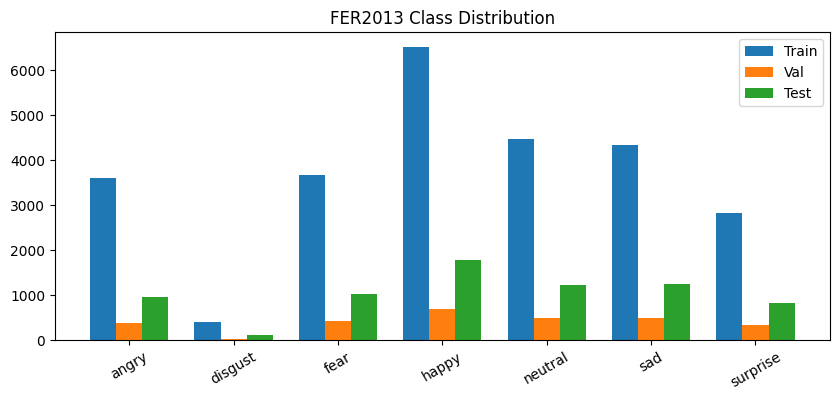

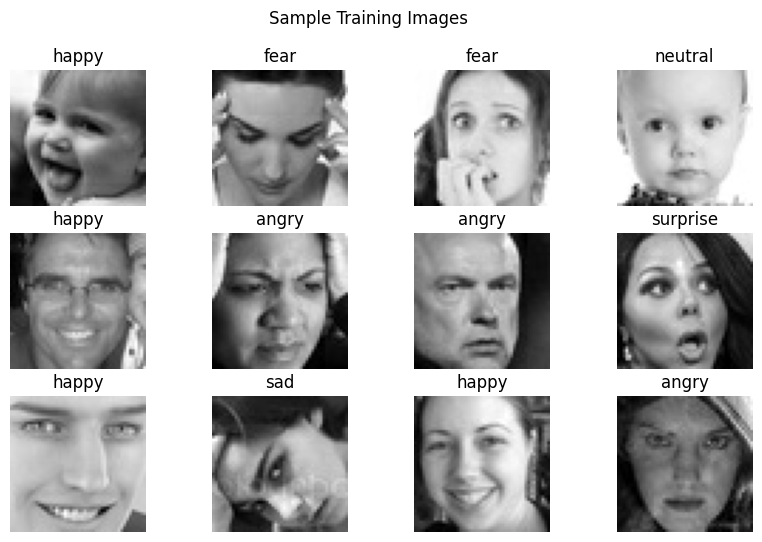

In [3]:
def count_labels(ds, num_classes):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    return counts

train_counts = count_labels(train_ds, NUM_CLASSES)
val_counts   = count_labels(val_ds, NUM_CLASSES)
test_counts  = count_labels(test_ds, NUM_CLASSES)

print("Train counts:", dict(zip(class_names, train_counts)))
print("Val counts  :", dict(zip(class_names, val_counts)))
print("Test counts :", dict(zip(class_names, test_counts)))

plt.figure(figsize=(10,4))
x = np.arange(NUM_CLASSES)
plt.bar(x - 0.25, train_counts, width=0.25, label="Train")
plt.bar(x,        val_counts,   width=0.25, label="Val")
plt.bar(x + 0.25, test_counts,  width=0.25, label="Test")
plt.xticks(x, class_names, rotation=30)
plt.title("FER2013 Class Distribution")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()


## 4. Preprocessing: crop to 40×40, normalize to [-1,1], augmentation + Random Erasing

In [4]:
TARGET_SIZE = (40, 40)

# Normalize: [0..255] -> [-1..1]
normalizer = layers.Rescaling(1./127.5, offset=-1)

# Train augmentation (VGG-like baseline style)
train_aug = keras.Sequential([
    layers.RandomCrop(TARGET_SIZE[0], TARGET_SIZE[1]),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomTranslation(0.08, 0.08),
], name="train_aug")

# Val/Test: deterministic crop
center_crop = keras.Sequential([
    layers.CenterCrop(TARGET_SIZE[0], TARGET_SIZE[1]),
], name="center_crop")


class RandomErasing(layers.Layer):
    """Cutout/Random Erasing for grayscale images. Input: [B,H,W,C]."""
    def __init__(self, p=0.5, min_frac=0.08, max_frac=0.25, fill=-1.0, **kwargs):
        super().__init__(**kwargs)
        self.p = p
        self.min_frac = min_frac
        self.max_frac = max_frac
        self.fill = fill

    def call(self, x, training=None):
        if training is None:
            training = tf.keras.backend.learning_phase()
        if not training:
            return x

        def erase_batch():
            return tf.map_fn(self._erase_one, x)

        r = tf.random.uniform([])
        return tf.cond(r < self.p, erase_batch, lambda: x)

    def _erase_one(self, img):
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]

        frac = tf.random.uniform([], self.min_frac, self.max_frac)
        er_h = tf.cast(tf.round(tf.cast(h, tf.float32) * frac), tf.int32)
        er_w = tf.cast(tf.round(tf.cast(w, tf.float32) * frac), tf.int32)
        er_h = tf.maximum(1, er_h)
        er_w = tf.maximum(1, er_w)

        y1 = tf.random.uniform([], 0, h - er_h + 1, dtype=tf.int32)
        x1 = tf.random.uniform([], 0, w - er_w + 1, dtype=tf.int32)
        y2 = y1 + er_h
        x2 = x1 + er_w

        yy = tf.range(h)[:, None]     # [H,1]
        xx = tf.range(w)[None, :]     # [1,W]
        in_y = tf.logical_and(yy >= y1, yy < y2)  # [H,1]
        in_x = tf.logical_and(xx >= x1, xx < x2)  # [1,W]
        cut = tf.logical_and(in_y, in_x)          # [H,W]
        cut = tf.expand_dims(cut, axis=-1)        # [H,W,1]

        cut = tf.cast(cut, img.dtype)
        return img * (1.0 - cut) + tf.cast(self.fill, img.dtype) * cut


rand_erase = RandomErasing(p=0.5, min_frac=0.08, max_frac=0.25, fill=-1.0)

def preprocess_train(x, y):
    x = tf.cast(x, tf.float32)
    x = train_aug(x, training=True)
    x = normalizer(x)
    x = rand_erase(x, training=True)
    return x, y

def preprocess_eval(x, y):
    x = tf.cast(x, tf.float32)
    x = center_crop(x, training=False)
    x = normalizer(x)
    return x, y

train_ds_p = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds_p   = val_ds.map(preprocess_eval,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds_p  = test_ds.map(preprocess_eval,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

for xb, yb in train_ds_p.take(1):
    print("Batch:", xb.shape, xb.dtype, "min/max:", float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))


Batch: (128, 40, 40, 1) <dtype: 'float32'> min/max: -1.0 1.0


## 5. Class weights (optional)
Set `USE_CLASS_WEIGHTS=False` if training becomes unstable.

In [5]:
USE_CLASS_WEIGHTS = True

total = train_counts.sum()
class_weights = {i: float(total / (NUM_CLASSES * train_counts[i])) for i in range(NUM_CLASSES)}
print("Raw class weights:", class_weights)

# cap extreme weights
class_weights = {k: min(v, 5.0) for k, v in class_weights.items()}
print("Capped class weights:", class_weights)


Raw class weights: {0: 1.02223365114531, 1: 9.297948902482908, 2: 1.0063483408630627, 3: 0.5660612964707429, 4: 0.8246840291076216, 5: 0.8497434885556433, 6: 1.3080388782018832}
Capped class weights: {0: 1.02223365114531, 1: 5.0, 2: 1.0063483408630627, 3: 0.5660612964707429, 4: 0.8246840291076216, 5: 0.8497434885556433, 6: 1.3080388782018832}


## 6. Models: MLP baseline, Small CNN, VGG-like CNN (from scratch)

In [6]:
L2 = 1e-4
DROPOUT = 0.5

def build_mlp():
    inp = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1))
    x = layers.Flatten()(inp)
    x = layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return keras.Model(inp, out, name="MLP")

def build_small_cnn():
    inp = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1))

    x = layers.Conv2D(32, 3, padding="same", kernel_regularizer=keras.regularizers.l2(L2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return keras.Model(inp, out, name="CNN_Small")

def build_vgg_like():
    inp = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1))

    def vgg_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", kernel_regularizer=keras.regularizers.l2(L2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding="same", kernel_regularizer=keras.regularizers.l2(L2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D(2)(x)
        return x

    x = vgg_block(inp, 64)    # 40 -> 20
    x = vgg_block(x, 128)     # 20 -> 10
    x = vgg_block(x, 256)     # 10 -> 5
    x = vgg_block(x, 512)     # 5 -> 2

    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = layers.Dropout(DROPOUT)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return keras.Model(inp, out, name="VGG_Like_Small")

for m in [build_mlp(), build_small_cnn(), build_vgg_like()]:
    print("\n====", m.name, "====")
    m.summary()
    print("Total layers:", len(m.layers))
    print("Total params:", m.count_params())



==== MLP ====


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,839 (3.63 MB)

 Trainable params: 952,839 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

Total layers: 7
Total params: 952839

==== CNN_Small ====


Model: "CNN_Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,823 (3.49 MB)

 Trainable params: 914,375 (3.49 MB)

 Non-trainable params: 448 (1.75 KB)

Total layers: 17
Total params: 914823

==== VGG_Like_Small ====


Model: "VGG_Like_Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             

 Total params: 7,318,471 (27.92 MB)

 Trainable params: 7,314,631 (27.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

Total layers: 35
Total params: 7318471


## 7. Training utilities (sparse label smoothing + plots + evaluation)

In [7]:
def sparse_cce_with_label_smoothing(num_classes: int, label_smoothing: float):
    label_smoothing = float(label_smoothing)

    def loss(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)  # (B,)
        y = tf.one_hot(y_true, depth=num_classes)             # (B,C)
        y = y * (1.0 - label_smoothing) + (label_smoothing / num_classes)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        return -tf.reduce_sum(y * tf.math.log(y_pred), axis=-1)  # (B,)
    return loss

def compile_model(model, lr=0.01, label_smoothing=0.0):
    opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    if label_smoothing and label_smoothing > 0:
        loss = sparse_cce_with_label_smoothing(NUM_CLASSES, label_smoothing)
    else:
        loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model

def plot_history(hist, title="Training Curves"):
    h = hist.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.title(title + " - Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.show()

def eval_and_report(model, ds, name="Model"):
    y_true = []
    y_pred = []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        y_true.extend(y.numpy().tolist())
        y_pred.extend(np.argmax(p, axis=1).tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = float((y_true == y_pred).mean())
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))

    print(f"\n=== {name} (Test) ===")
    print("Accuracy:", acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} - Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(NUM_CLASSES)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    thresh = cm.max() * 0.6
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=9)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    return acc, macro_f1


## 8. Train baselines (MLP + Small CNN)

Epoch 1/20


I0000 00:00:1765716491.362579     287 service.cc:148] XLA service 0x78d0c00038a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765716491.363102     287 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765716491.572239     287 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1836 - loss: 2.0363

I0000 00:00:1765716493.184578     287 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


202/202 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.1945 - loss: 1.9636 - val_accuracy: 0.2620 - val_loss: 1.9381 - learning_rate: 0.0100
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.2178 - loss: 1.8853 - val_accuracy: 0.2732 - val_loss: 1.9361 - learning_rate: 0.0100
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.2255 - loss: 1.8728 - val_accuracy: 0.2780 - val_loss: 1.9239 - learning_rate: 0.0100
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.2286 - loss: 1.8669 - val_accuracy: 0.2930 - val_loss: 1.9207 - learning_rate: 0.0100
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.2400 - loss: 1.8588 - val_accuracy: 0.3052 - val_loss: 1.9114 - learning_rate: 0.0100
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.2439 - loss: 1.8604 - val_accuracy: 0.2986 - val_loss: 1.9127 - learning_rate: 0.0100
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.2425 - loss: 1.8594

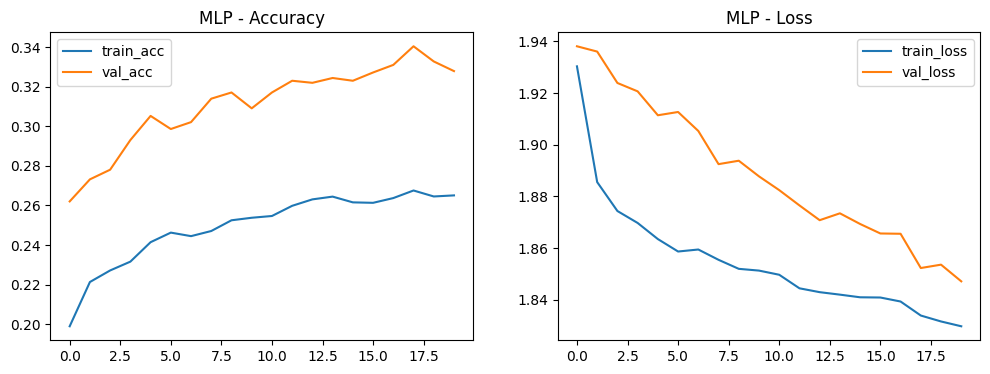


=== MLP (Test) ===
Accuracy: 0.3485650599052661
Macro F1: 0.2488429724171568

Classification Report:
               precision    recall  f1-score   support

       angry       0.26      0.15      0.19       958
     disgust       0.00      0.00      0.00       111
        fear       0.21      0.03      0.05      1024
       happy       0.43      0.65      0.51      1774
     neutral       0.29      0.34      0.32      1233
         sad       0.34      0.24      0.28      1247
    surprise       0.31      0.56      0.40       831

    accuracy                           0.35      7178
   macro avg       0.26      0.28      0.25      7178
weighted avg       0.32      0.35      0.31      7178



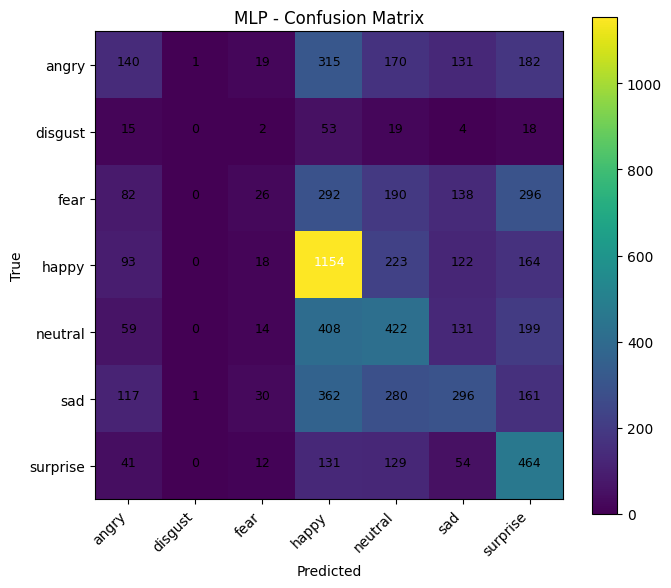

Epoch 1/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.1887 - loss: 2.0111 - val_accuracy: 0.2338 - val_loss: 1.9244 - learning_rate: 0.0100
Epoch 2/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2102 - loss: 1.8333 - val_accuracy: 0.2655 - val_loss: 1.8990 - learning_rate: 0.0100
Epoch 3/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2185 - loss: 1.8258 - val_accuracy: 0.2557 - val_loss: 1.8625 - learning_rate: 0.0100
Epoch 4/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2338 - loss: 1.8186 - val_accuracy: 0.2662 - val_loss: 1.8478 - learning_rate: 0.0100
Epoch 5/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2249 - loss: 1.8186 - val_accuracy: 0.2164 - val_loss: 1.9034 - learning_rate: 0.0100
Epoch 6/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2484 - loss: 1.8041 - val_accuracy: 0.2373 - val_loss: 1.9354 - learning_rate: 0.0100
Epoch 7/35
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.2561 - l

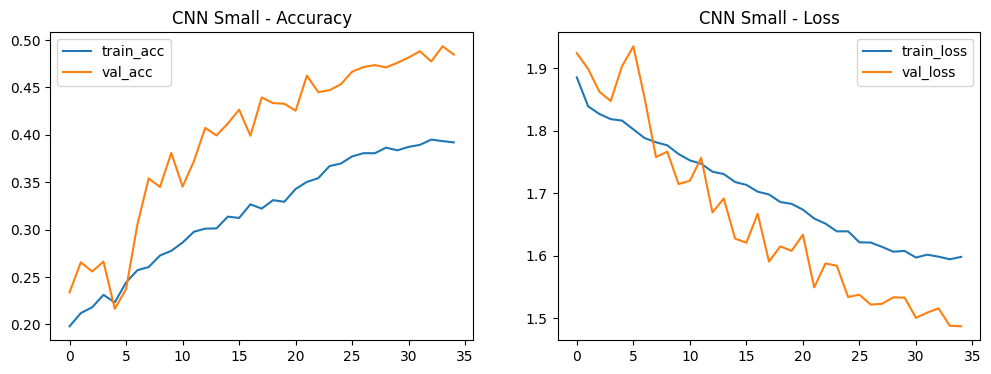


=== CNN Small (Test) ===
Accuracy: 0.5001393145723043
Macro F1: 0.4251384951923482

Classification Report:
               precision    recall  f1-score   support

       angry       0.34      0.41      0.37       958
     disgust       0.38      0.18      0.25       111
        fear       0.28      0.11      0.16      1024
       happy       0.70      0.78      0.74      1774
     neutral       0.45      0.55      0.49      1233
         sad       0.41      0.28      0.33      1247
    surprise       0.53      0.80      0.64       831

    accuracy                           0.50      7178
   macro avg       0.44      0.44      0.43      7178
weighted avg       0.47      0.50      0.47      7178



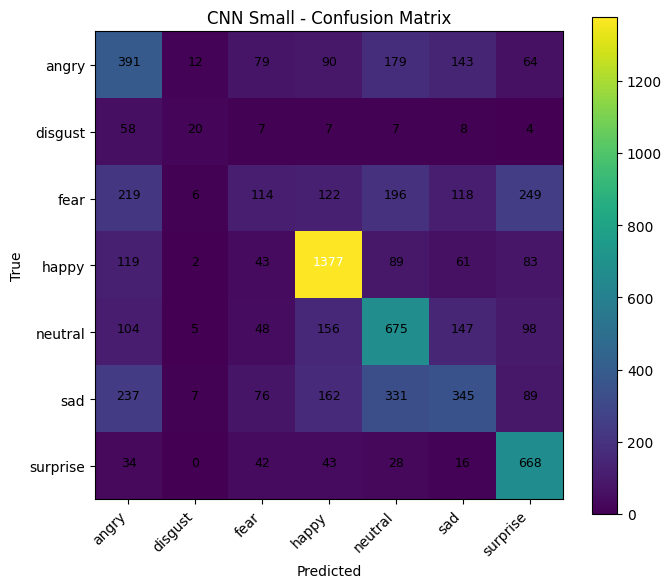

In [8]:
RUN_BASELINES = True
results = []

if RUN_BASELINES:
    # ---- MLP ----
    mlp = compile_model(build_mlp(), lr=0.01, label_smoothing=0.0)
    cb = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    ]
    hist_mlp = mlp.fit(
        train_ds_p,
        validation_data=val_ds_p,
        epochs=20,
        class_weight=(class_weights if USE_CLASS_WEIGHTS else None),
        callbacks=cb,
        verbose=1
    )
    plot_history(hist_mlp, "MLP")
    acc, mf1 = eval_and_report(mlp, test_ds_p, "MLP")
    results.append(("MLP", acc, mf1))

    # ---- Small CNN ----
    cnn = compile_model(build_small_cnn(), lr=0.01, label_smoothing=0.05)
    cb = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ]
    hist_cnn = cnn.fit(
        train_ds_p,
        validation_data=val_ds_p,
        epochs=35,
        class_weight=(class_weights if USE_CLASS_WEIGHTS else None),
        callbacks=cb,
        verbose=1
    )
    plot_history(hist_cnn, "CNN Small")
    acc, mf1 = eval_and_report(cnn, test_ds_p, "CNN Small")
    results.append(("CNN Small", acc, mf1))


## 9. Train the main VGG-like model (from scratch)

Epoch 1/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1725 - loss: 2.4060
Epoch 1: val_accuracy improved from -inf to 0.23937, saving model to best_vgg_like.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.1725 - loss: 2.4051 - val_accuracy: 0.2394 - val_loss: 2.2512 - learning_rate: 0.0100
Epoch 2/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2012 - loss: 2.1550
Epoch 2: val_accuracy improved from 0.23937 to 0.24704, saving model to best_vgg_like.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.2012 - loss: 2.1550 - val_accuracy: 0.2470 - val_loss: 2.2374 - learning_rate: 0.0100
Epoch 3/60
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2010 - loss: 2.1446
Epoch 3: val_accuracy improved from 0.24704 to 0.27491, saving model to best_vgg_like.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.2010 - loss: 2.1446 - val_accuracy: 0.2749 - val_loss: 2.2077 - learning_rate: 0.0100
Epoch 4/60
201/202 ━━━━━━━━━━━━━━━━━

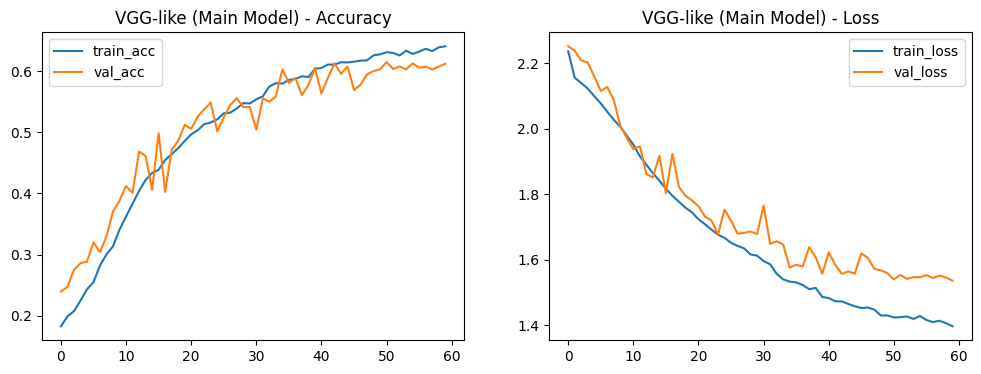


=== VGG-like (Test) ===
Accuracy: 0.6051825020897186
Macro F1: 0.5787540638799972

Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.57      0.54       958
     disgust       0.52      0.52      0.52       111
        fear       0.42      0.39      0.40      1024
       happy       0.90      0.78      0.84      1774
     neutral       0.54      0.62      0.58      1233
         sad       0.49      0.43      0.46      1247
    surprise       0.66      0.79      0.72       831

    accuracy                           0.61      7178
   macro avg       0.58      0.59      0.58      7178
weighted avg       0.61      0.61      0.61      7178



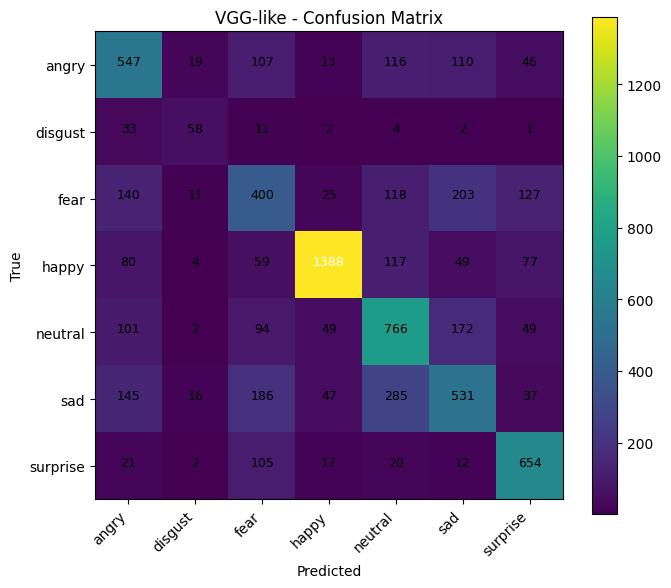

Saved: best_vgg_like.keras and class_names.json


In [9]:
vgg = build_vgg_like()
vgg = compile_model(vgg, lr=0.01, label_smoothing=0.10)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_vgg_like.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=4, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1),
]

history_vgg = vgg.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=60,
    class_weight=(class_weights if USE_CLASS_WEIGHTS else None),
    callbacks=callbacks,
    verbose=1
)

plot_history(history_vgg, "VGG-like (Main Model)")

acc, mf1 = eval_and_report(vgg, test_ds_p, "VGG-like")
results.append(("VGG-like", acc, mf1))

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved: best_vgg_like.keras and class_names.json")


## 10. Model comparison (accuracy + macro-F1)


=== Model Comparison (Test) ===
VGG-like     | acc=0.6052 | macroF1=0.5788
CNN Small    | acc=0.5001 | macroF1=0.4251
MLP          | acc=0.3486 | macroF1=0.2488


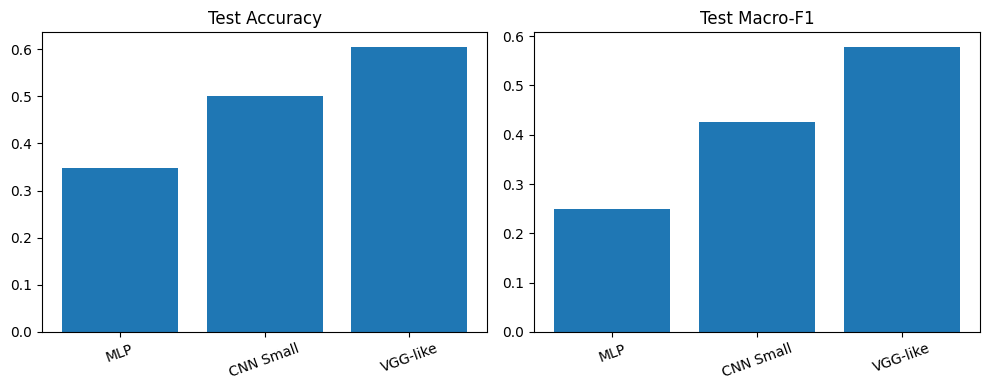

In [10]:
print("\n=== Model Comparison (Test) ===")
for name, acc, mf1 in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s} | acc={acc:.4f} | macroF1={mf1:.4f}")

labels = [r[0] for r in results]
accs   = [r[1] for r in results]
mf1s   = [r[2] for r in results]

x = np.arange(len(labels))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(x, accs)
plt.xticks(x, labels, rotation=20)
plt.title("Test Accuracy")

plt.subplot(1,2,2)
plt.bar(x, mf1s)
plt.xticks(x, labels, rotation=20)
plt.title("Test Macro-F1")

plt.tight_layout()
plt.show()


## 11. Prediction grid (screenshots for report)

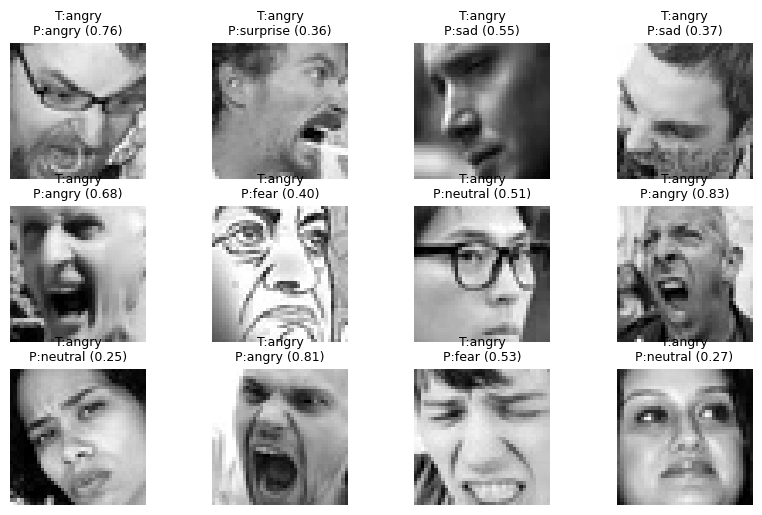

In [11]:
def show_predictions(model, ds, n=12):
    plt.figure(figsize=(10,6))
    shown = 0
    for x, y in ds.take(3):
        p = model.predict(x, verbose=0)
        pred = np.argmax(p, axis=1)
        conf = np.max(p, axis=1)
        for i in range(x.shape[0]):
            if shown >= n:
                plt.show()
                return
            ax = plt.subplot(3, 4, shown+1)
            img = x[i].numpy()
            img_disp = ((img + 1.0) * 127.5).astype(np.uint8)  # [-1,1] -> [0,255]
            plt.imshow(img_disp.squeeze(), cmap="gray")
            t = class_names[int(y[i])]
            pr = class_names[int(pred[i])]
            plt.title(f"T:{t}\nP:{pr} ({conf[i]:.2f})", fontsize=9)
            plt.axis("off")
            shown += 1
    plt.show()

show_predictions(vgg, test_ds_p, n=12)


## 12. Export final model for GUI app

In [12]:
final_model_path = "fer2013_vgg_like.keras"
vgg.save(final_model_path)
print("Saved:", final_model_path)

print("\nWorking directory files (Kaggle /kaggle/working):")
for f in sorted(os.listdir(".")):
    if f.endswith(".keras") or f.endswith(".json"):
        print(" -", f)


Saved: fer2013_vgg_like.keras

Working directory files (Kaggle /kaggle/working):
 - best_vgg_like.keras
 - class_names.json
 - fer2013_vgg_like.keras
